In [3]:
from datacube.utils.dask import start_local_dask
from dep_tools.loaders import LandsatOdcLoader
from dep_tools.namers import LocalPath
from dep_tools.writers import LocalDsWriter
from pystac import Item

from src.grid import grid
from src.run_task import GeoMADLandsatProcessor

from odc.geo.gridspec import GridSpec
from odc.geo import XY
import geopandas as gpd

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Optionally set up a local dask cluster
client = start_local_dask()
client.dashboard_link

'http://127.0.0.1:8787/status'

In [6]:
# Study site configuration
country_code = "PG"
region_index = "63,20"
datetime = "2022"
dep_path = LocalPath(
    local_folder="data",
    sensor="ls",
    dataset_id="geomad",
    version="0.0.0",
    time=datetime,
)
item_id = f"{country_code}_{region_index}"

# Set up a data loader
loader = LandsatOdcLoader(
    epsg=3832,
    datetime=datetime,
    dask_chunksize=dict(time=1, x=4096, y=4096),
    odc_load_kwargs=dict(
        fail_on_error=False,
        resolution=30,
        # bands=["qa_pixel", "red", "green", "blue", "nir08", "swir16", "swir22"],
        bands=["qa_pixel", "red", "green", "blue"]
    ),
    exclude_platforms=["landsat-7"],
    nodata_value=0,
    keep_ints=True,
    flat_array=True,
)

# And a data processor
processor = GeoMADLandsatProcessor(
    scale_and_offset=False,
    dilate_mask=True,
    work_chunks=(601, 601),
    num_threads=10,
    keep_ints=True
)

# And get the study site
pacific_gridspec = GridSpec(crs="EPSG:3832", tile_shape=(3200,3200), resolution=30, origin=XY(-3000000,-4000000))
geobox = pacific_gridspec.tile_geobox(XY(*map(float, region_index.split(","))))

cell = gpd.GeoDataFrame(geometry=[geobox.geographic_extent], crs=4326)

In [8]:
# Run the load process, which is lazy-loaded
input_data = loader.load(cell)
input_data

<xarray.Dataset>
Dimensions:      (y: 3201, x: 3200, time: 148)
Coordinates:
  * y            (y) float64 -1.984e+06 -1.984e+06 ... -2.08e+06 -2.08e+06
  * x            (x) float64 3.048e+06 3.048e+06 ... 3.144e+06 3.144e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2022-01-04T22:13:04.806556 ... 2022-12...
Data variables:
    qa_pixel     (time, y, x) uint16 dask.array<chunksize=(1, 3201, 3200), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3201, 3200), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3201, 3200), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3201, 3200), meta=np.ndarray>
Attributes:
    nodata:   0

In [9]:
# Plan the processing. Still lazy-loaded
output_data = processor.process(input_data)
output_data

<xarray.Dataset>
Dimensions:  (y: 3201, x: 3200)
Coordinates:
  * y        (y) float64 -1.984e+06 -1.984e+06 ... -2.08e+06 -2.08e+06
  * x        (x) float64 3.048e+06 3.048e+06 3.048e+06 ... 3.144e+06 3.144e+06
Data variables:
    red      (y, x) uint16 dask.array<chunksize=(601, 601), meta=np.ndarray>
    green    (y, x) uint16 dask.array<chunksize=(601, 601), meta=np.ndarray>
    blue     (y, x) uint16 dask.array<chunksize=(601, 601), meta=np.ndarray>
    emad     (y, x) float32 dask.array<chunksize=(601, 601), meta=np.ndarray>
    smad     (y, x) float32 dask.array<chunksize=(601, 601), meta=np.ndarray>
    bcmad    (y, x) float32 dask.array<chunksize=(601, 601), meta=np.ndarray>
    count    (y, x) uint16 dask.array<chunksize=(601, 601), meta=np.ndarray>
Attributes:
    nodata:           0
    stac_properties:  {'start_datetime': '2022-01-01T00:00:00.000Z', 'datetim...

In [10]:
loaded = output_data.compute()

/opt/homebrew/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


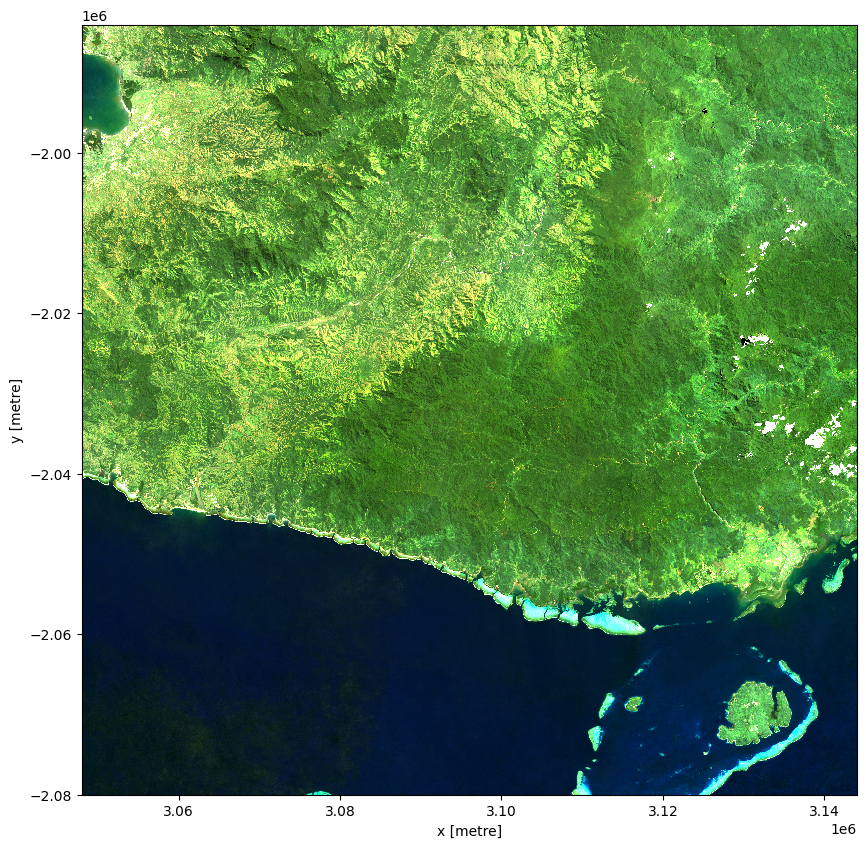

In [11]:
loaded[["red", "green", "blue"]].to_array().plot.imshow(robust=True, figsize=(10, 10))

In [ ]:
writer = LocalDsWriter(itempath=dep_path)
out_files = writer.write(output_data, item_id)

In [ ]:
# Make sure written files are readable
stac_path = writer.itempath.path(item_id, ext=".stac-item.json")

item = Item.from_file(stac_path)
item.validate()